In [1]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
env = gym.make('FrozenLake8x8-v0')

n_state = env.nS
n_action = env.nA

print(n_state)
print(n_action)

64
4


Policy Iteration

In [3]:
def plot_graph(param, curves, param_name="", curve_name=""):
    colors = ['deepskyblue', 'red', 'yellow', 'green', 'midnightblue', 'fuchsia']
    plt.figure()
    lines = []
    l, = plt.plot(param, curves, ls='-', marker='+', color='deepskyblue')
    lines.append(l)
    plt.xlabel(param_name)
    plt.ylabel(curve_name)
    
    plt.show()

In [4]:
def plot_graphs(param, curves, curve_labels, param_name="", curve_name=""):
    colors = ['firebrick', 'cadetblue', 'darksalmon', 'mediumseagreen', 'darkmagenta', 'skyblue', 
              'gold','palevioletred', 'olive', 'darkorange', 'mediumpurple', 'slategray', 'darkseagreen']
    plt.figure()
    lines = []
    for i in range(len(curve_labels)):
        l, = plt.plot(param, curves[i,:], ls='-', marker='', color=colors[i])
        lines.append(l)
    plt.xlabel(param_name)
    plt.ylabel(curve_name)
    
    plt.legend(handles=lines, labels=curve_labels, loc='best')
    plt.show()

In [5]:
def eval_state_action(state_value, s, a, gamma=0.9):
    return np.sum([prob * (reward + gamma * state_value[next_state]) for prob, next_state, reward, _ in env.P[s][a] ])

In [6]:
def get_policy(state_value, gamma=0.9):
    policy = np.zeros(n_state)
    
    for state in range(n_state):
        all_a_values = []
        for action in range(n_action):
            tmp_st_val = eval_state_action(state_value, state, action, gamma)
            all_a_values.append(tmp_st_val)
        best_a = np.argmax(np.asarray(all_a_values))
        policy[state] = best_a
    
    return policy

In [7]:
def get_scores(policy, episodes=1000):
    misses = 0
    steps_list = []
    
    for episode in range(episodes):
        observation = env.reset()
        steps = 0
        while True:
            action = policy[observation]
            observation, reward, done, info = env.step(action)
            steps += 1
            if done and reward == 1:
                steps_list.append(steps)
                break
            elif done and reward == 0:
                misses += 1
                break
    mean_steps = np.mean(steps_list)
    per_misses = (misses/episodes) * 100
    return mean_steps, per_misses

In [8]:
def policy_evaluation(state_value, policy, eps=0.0001, gamma=0.9):
    while True:
        delta = 0
        for state in range(n_state):
            v = state_value[state]
            state_value[state] = eval_state_action(state_value, state, policy[state], gamma)
            delta = max(delta, np.abs(v - state_value[state]))
        if delta < eps:
            break

In [9]:
def policy_improvement(state_value, policy, gamma):
    policy_no_stable = 0
    for state in range(n_state):
        a = policy[state]
        policy[state] = np.argmax([eval_state_action(state_value, state, a, gamma) for a in range(n_action)])
        if a != policy[state]:
            policy_no_stable += 1
    return policy_no_stable

In [10]:
def policy_iteration(num_iter=1000, eps=0.0001, gamma=0.9):
    pi_state_values = np.zeros(n_state)
    pi_policy = np.zeros(n_state)
    pi_it_stable = 60
    
    it_conv = num_iter
    start_time = time.time()
    conv_time = 0
    
    for i in range(num_iter):
        policy_evaluation(pi_state_values, pi_policy, eps, gamma=gamma)
        pi_it_stable = policy_improvement(pi_state_values, pi_policy, gamma=gamma)
        if pi_it_stable == 0:
            pi_iteration_st = i
            it_conv = i + 1
            conv_time = time.time() - start_time
            break
        
    print("max iter:", num_iter, ", gamma:", gamma, ", conv iter:", it_conv, ", conv time:", conv_time, "policy instable:", pi_it_stable)
    return pi_policy
    

In [11]:
def run_iterations(gamma, eps, max_iter):
    state_values = np.zeros(n_state)
    policy = np.zeros(n_state)
    tot_V = []
    
    for i in range(max_iter):
        policy_evaluation(state_values, policy, eps=eps, gamma=gamma)
        pi_it_stable = policy_improvement(state_values, policy, gamma=gamma)
        tot_V.append(np.sum(state_values))
        
    return tot_V

In [12]:
max_iterations_gamma = 30
gamma_list = np.arange(0.1, 1.1, 0.1)
tot_V_gammas = np.zeros((len(gamma_list), max_iterations_gamma))
i = 0
for g in gamma_list:
    tot_V_gammas[i,:] = run_iterations(gamma=g, eps=0.0001, max_iter=max_iterations_gamma)
    i += 1

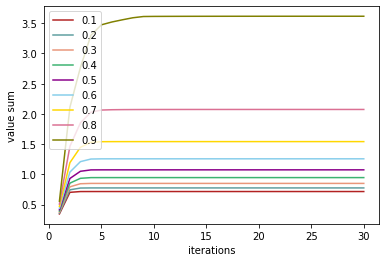

In [13]:
plot_graphs(range(1,max_iterations_gamma+1), tot_V_gammas, 
            ["0.1","0.2","0.3","0.4","0.5","0.6","0.7","0.8","0.9"], 
            param_name="iterations", curve_name="value sum")

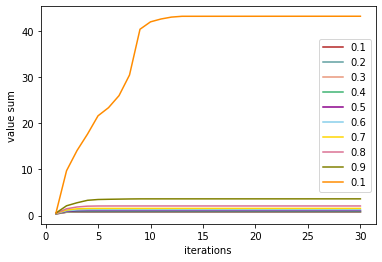

In [14]:
plot_graphs(range(1, max_iterations_gamma+1), tot_V_gammas, 
            ["0.1","0.2","0.3","0.4","0.5","0.6","0.7","0.8","0.9","0.1"], 
            param_name="iterations", curve_name="value sum")

In [15]:
max_iterations_epsilon = 50
epsilon_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
tot_V_eps = np.zeros((len(epsilon_list), max_iterations_epsilon))
i = 0
for e in epsilon_list:
    tot_V_eps[i,:] = run_iterations(gamma=0.9, eps=e, max_iter=max_iterations_epsilon)
    i += 1

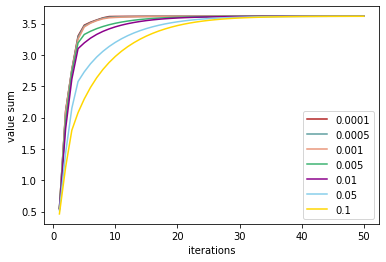

In [16]:
plot_graphs(range(1, max_iterations_epsilon+1), tot_V_eps, 
            ["0.0001","0.0005","0.001","0.005","0.01","0.05","0.1"], 
            param_name="iterations", curve_name="value sum")

In [21]:
pi_gamma_list = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 
                 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
l_pi_gamma_list = len(pi_gamma_list)

# vi_mean_steps, vi_per_misses
scores_test_pi_gamma = np.zeros((2, l_pi_gamma_list))
for i in range(l_pi_gamma_list):
    pi_policy = policy_iteration(num_iter=100000, eps=0.001, gamma=pi_gamma_list[i])
    
    scores_test_pi_gamma[:, i] = get_scores(pi_policy, episodes=1000)

max iter: 100000 , gamma: 0.1 , conv iter: 9 , conv time: 0.053261518478393555 policy instable: 0
max iter: 100000 , gamma: 0.15 , conv iter: 11 , conv time: 0.05770540237426758 policy instable: 0
max iter: 100000 , gamma: 0.2 , conv iter: 14 , conv time: 0.06746292114257812 policy instable: 0
max iter: 100000 , gamma: 0.25 , conv iter: 13 , conv time: 0.06869220733642578 policy instable: 0
max iter: 100000 , gamma: 0.3 , conv iter: 11 , conv time: 0.05727267265319824 policy instable: 0
max iter: 100000 , gamma: 0.35 , conv iter: 11 , conv time: 0.05147242546081543 policy instable: 0
max iter: 100000 , gamma: 0.4 , conv iter: 10 , conv time: 0.05180954933166504 policy instable: 0
max iter: 100000 , gamma: 0.45 , conv iter: 12 , conv time: 0.06387114524841309 policy instable: 0
max iter: 100000 , gamma: 0.5 , conv iter: 11 , conv time: 0.053765058517456055 policy instable: 0
max iter: 100000 , gamma: 0.55 , conv iter: 11 , conv time: 0.06233024597167969 policy instable: 0
max iter: 1000

In [29]:
print(scores_test_pi_gamma)

[[70.35728953 67.84453782 72.18472469 70.22144112 68.42242991 71.75415896
  73.90340909 70.00373134 71.34528302 70.06282723 68.84053156 67.27018122
  72.39460371 71.83774834 68.22333333 71.32698413 71.24858757 73.91777188
  96.63870246]
 [51.3        52.4        43.7        43.1        46.5        45.9
  47.2        46.4        47.         42.7        39.8        39.3
  40.7        39.6        40.         37.         29.2        24.6
  10.6       ]]


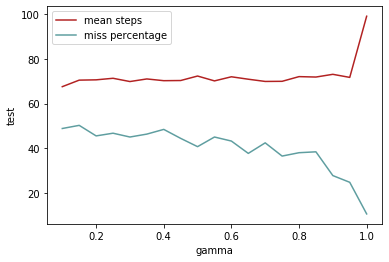

In [18]:
plot_graphs(pi_gamma_list, scores_test_pi_gamma, ["mean steps", "miss percentage"], param_name="gamma", curve_name="test")

In [27]:
pi_eps_list = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
l_pi_eps_list = len(pi_eps_list)

scores_test_pi_eps = np.zeros((2, l_pi_eps_list))
for i in range(l_pi_eps_list):
    pi_state_values = np.zeros(n_state)
    pi_state_values = policy_iteration(num_iter=100000, eps=pi_eps_list[i], gamma=0.9)
    pi_policy = get_policy(pi_state_values)
    scores_test_pi_eps[:, i] = get_scores(pi_policy, episodes=1000)

max iter: 100000 , gamma: 0.9 , conv iter: 13 , conv time: 0.08335590362548828 policy instable: 0
max iter: 100000 , gamma: 0.9 , conv iter: 10 , conv time: 0.053124189376831055 policy instable: 0
max iter: 100000 , gamma: 0.9 , conv iter: 10 , conv time: 0.05495309829711914 policy instable: 0
max iter: 100000 , gamma: 0.9 , conv iter: 16 , conv time: 0.09243321418762207 policy instable: 0
max iter: 100000 , gamma: 0.9 , conv iter: 12 , conv time: 0.09940099716186523 policy instable: 0
max iter: 100000 , gamma: 0.9 , conv iter: 10 , conv time: 0.11062240600585938 policy instable: 0
max iter: 100000 , gamma: 0.9 , conv iter: 10 , conv time: 0.13848209381103516 policy instable: 0


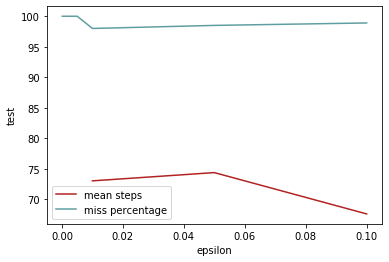

In [28]:
plot_graphs(pi_eps_list, scores_test_pi_eps, ["mean steps", "miss percentage"], param_name="epsilon", curve_name="test")